# Testing SR-IS vs SR on 4-room replanning

In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym

import gym_env
from utils import test_agent, get_full_maze_values, create_mapping_nb
from models import SR_IS, SR_TD

In [4]:
# Set the seed
seed = 26
np.random.seed(seed)
seeds = np.arange(40)

# Save dir
save_dir = os.path.join('..', 'figures/')

In [5]:
# Model Hyperparams 
reward = -0.2
term_reward = 10
alpha = 0.1
beta = 1.0
_lambda = 1.0
num_steps = 15000
num_simulations = 20

# Original term state
# learn_term_state = (6,6)
learn_term_state = (0,6)

# New term states
# term_states = {
#     "same" : [(4,6), (6,4)],
#     "different" : [(0,4), (0,6), (2,6), (4,0), (6,0), (6,2)],
# }
term_states = {
    "same" : [(0,4), (2,6)],
    "different" : [(4,6), (6,4), (6,6), (4,0), (6,0), (6,2)],
}

In [6]:
env = gym.make("four-room-sg")
maze = env.unwrapped.maze
mapping = create_mapping_nb(env.unwrapped.maze, env.unwrapped.get_walls())

In [7]:
avgs_random = {
    'same':{'mean':[],'median':[]},
    'different':{'mean':[],'median':[]}
}
avgs_sr = {
    'same':{'mean':[],'median':[]},
    'different':{'mean':[],'median':[]}
}
avgs_sr_is = {
    'same':{'mean':[],'median':[]},
    'different':{'mean':[],'median':[]}
}

In [8]:
# Loop through the seeds
for seed in seeds:
    print(f"Seed: {seed}")
    ##  Learning Phase  ##
    # Initialize agents
    SR_IS_agent = SR_IS(env_name="four-room-sg", reward=reward, term_reward=reward, _lambda=_lambda, beta=beta, alpha=alpha, num_steps=num_steps, policy="softmax", imp_samp=True)
    Random_agent = SR_IS(env_name="four-room-sg", reward=reward, term_reward=reward, _lambda=_lambda, beta=beta, num_steps=num_steps, policy="random", imp_samp=False)
    SR_agent = SR_TD(env_name="four-room-tr", gamma=0.95, reward=0,  term_reward=10, beta=beta, alpha=0.2, num_steps=num_steps, policy="softmax")

    # Base reward vectors
    r_base_is = np.copy(SR_IS_agent.r)
    r_base_sr = np.copy(SR_agent.r)

    # Learning reward vectors
    # SR-IS
    r_learn_is = np.copy(SR_IS_agent.r)
    r_learn_is[mapping[learn_term_state]] = term_reward
    SR_IS_agent.expr_t = np.exp(r_learn_is[SR_IS_agent.terminals] / _lambda)
    SR_IS_agent.r = r_learn_is

    # SR
    r_learn_sr = np.copy(SR_agent.r)
    r_learn_sr[mapping[learn_term_state]] = term_reward
    SR_agent.r = r_learn_sr

    # Lear
    SR_IS_agent.learn(seed=int(seed))
    SR_agent.learn(seed=int(seed))


    ##  Reval Phase  ##
    # Loop through the different terminal states
    for room, terminal_locs in term_states.items():
        # Loop through the different terminal locations
        for term_loc in terminal_locs:
            term_idx = mapping[term_loc]
            # Construct new reward vectors for SR-IS and SR agents
            r_new_is = np.copy(r_base_is)
            r_new_is[term_idx] = term_reward
            r_new_sr = np.copy(r_base_sr)
            r_new_sr[term_idx] = term_reward

            # Use new reward vector to update representations
            SR_IS_agent.r = r_new_is
            SR_agent.r = r_new_sr

            # Update SR-IS
            SR_IS_agent.expr_t = np.exp(r_new_is[SR_IS_agent.terminals] / _lambda)
            SR_IS_agent.update_V()

            # Update SR
            SR_agent.update_V()

            # Test the agents
            # Initialize holders and run simulations
            SR_IS_avg, Random_avg, SR_td_avg = [],[],[]
            for i in range(num_simulations):
                SR_IS_avg.append(len(test_agent(agent=SR_IS_agent, policy=SR_IS_agent.policy, seed=int(seed), term_state=term_loc)))
                Random_avg.append(len(test_agent(agent=Random_agent, policy=Random_agent.policy, seed=int(seed), term_state=term_loc)))
                SR_td_avg.append(len(test_agent(agent=SR_agent, policy=SR_agent.policy, seed=int(seed), term_state=term_loc)))
            
            # Append mean and median to main holder
            avgs_sr_is[room]['mean'].append(np.mean(SR_IS_avg))
            avgs_sr_is[room]['median'].append(np.median(SR_IS_avg))
            avgs_random[room]['mean'].append(np.mean(Random_avg))
            avgs_random[room]['median'].append(np.median(Random_avg))
            avgs_sr[room]['mean'].append(np.mean(SR_td_avg))
            avgs_sr[room]['median'].append(np.median(SR_td_avg))

Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Seed: 10
Seed: 11
Seed: 12
Seed: 13
Seed: 14
Seed: 15
Seed: 16
Seed: 17
Seed: 18
Seed: 19
Seed: 20
Seed: 21
Seed: 22
Seed: 23
Seed: 24
Seed: 25
Seed: 26
Seed: 27
Seed: 28
Seed: 29
Seed: 30
Seed: 31
Seed: 32
Seed: 33
Seed: 34
Seed: 35
Seed: 36
Seed: 37
Seed: 38
Seed: 39


In [9]:
stat_type = 'mean'
rooms = ['same', 'different']
avgs = [avgs_random, avgs_sr, avgs_sr_is]

means = [np.mean(avg[room][stat_type]) for room in rooms for avg in avgs]
sems = [np.std(avg[room][stat_type]) / np.sqrt(len(avg[room][stat_type])) for room in rooms for avg in avgs]
print(means)
print(sems)

[163.15, 32.125, 12.375, 219.925, 329.2, 21.325]
[15.842536689242667, 2.3778519061329284, 0.5013653233920351, 12.909768756266617, 38.99085327213151, 1.1991797688651837]


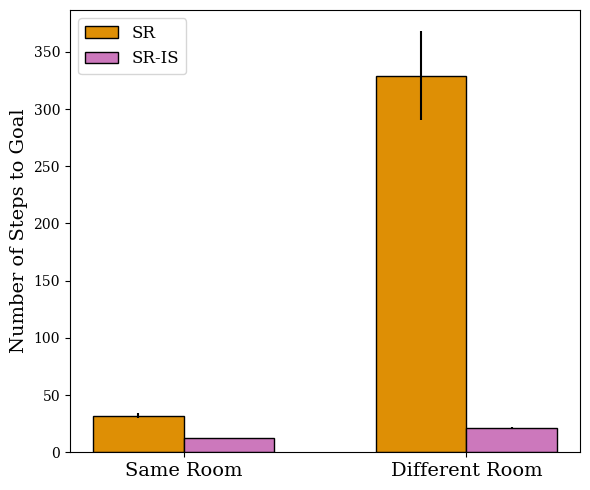

In [ ]:
# Set style parameters
plt.rcParams['font.family'] = 'serif'

save_path = None
# save_path = save_dir + "four-room-replan_v2.png"
stat_type = 'mean'

# Prepare data
rooms = ['same', 'different']
avgs = [avgs_random, avgs_sr, avgs_sr_is]

means = [np.mean(avg[room][stat_type]) for room in rooms for avg in avgs]
sems = [np.std(avg[room][stat_type]) / np.sqrt(len(avg[room][stat_type])) for room in rooms for avg in avgs]

# Create figure
plt.figure(figsize=(6, 5))

# Set bar positions
bar_width = 0.32
r1 = np.arange(2)  # positions for 'same' and 'different'
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create color palette
palette = sns.color_palette("colorblind")

# Create bars with black edges
# plt.bar(r1, [means[0], means[3]], width=bar_width, label='Random', 
#         color=palette[0], yerr=[sems[0], sems[3]], capsize=0, 
#         edgecolor='black', linewidth=1)
plt.bar(r1, [means[1], means[4]], width=bar_width, label='SR', 
        color=palette[1], yerr=[sems[1], sems[4]], capsize=0, 
        edgecolor='black', linewidth=1)
plt.bar(r2, [means[2], means[5]], width=bar_width, label='SR-IS', 
        color=palette[4], yerr=[sems[2], sems[5]], capsize=0, 
        edgecolor='black', linewidth=1)

# Add labels and title
plt.ylabel(f'Number of Steps to Goal', fontsize=14)

# Add xticks
plt.xticks([r + bar_width/2 for r in range(2)], ['Same Room', 'Different Room'], fontsize=14)

# Add legend
plt.legend(fontsize=12, loc='upper left')

# Adjust layout
plt.tight_layout()

# Save if path provided
if save_path:
    plt.savefig(save_path, bbox_inches='tight', dpi=300)

# Show plot
plt.show()